In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input/PX-WTI价差拟合残差_美国RBOB汽油裂解.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['PX-WTI价差拟合残差/美国RBOB汽油裂解'].last_valid_index()

sheet.head() 

,PX-WTI价差拟合残差/美国RBOB汽油裂解,PTA周度产量,山东地炼常减压开工率（%）,PTA总库存超季节性（5Y）
Date,,,,
2014-06-18,NaN,NaN,40.19,NaN
2014-07-02,NaN,NaN,42.39,NaN
2014-07-09,NaN,NaN,36.82,NaN
2014-07-23,NaN,NaN,36.70,NaN
2014-08-01,294.5685,NaN,NaN,NaN


In [3]:
sheet.columns  

Index(['PX-WTI价差拟合残差/美国RBOB汽油裂解', 'PTA周度产量', '山东地炼常减压开工率（%）',
       'PTA总库存超季节性（5Y）'],
      dtype='object')

In [4]:

################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
if len(future_data_30days) == 0:
    new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

elif future_data_30days.index.max() > target_end:
    sheet = sheet[sheet.index <= target_end]
    new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))
else:
    max_future_date = future_data_30days.index.max() if len(future_data_30days) > 0 else last_day
    new_index = pd.date_range(start=max_future_date+ pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet.sort_index()

################################# 处理缺失值 #################################
fill_methods = {
    'PTA周度产量': 'interpolate',
    '山东地炼常减压开工率（%）': 'interpolate',
    'PTA总库存超季节性（5Y）': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, 'PX-WTI价差拟合残差/美国RBOB汽油裂解'] = sheet.loc[:last_day, 'PX-WTI价差拟合残差/美国RBOB汽油裂解'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['PTA周度产量_提前45天'] = sheet['PTA周度产量'].shift(45)
sheet['山东地炼常减压开工率（%）_提前25天'] = sheet['山东地炼常减压开工率（%）'].shift(25)
sheet['PTA总库存超季节性（5Y）_提前20天'] = sheet['PTA总库存超季节性（5Y）'].shift(20)

sheet['PTA周度产量_提前45天_逆序'] = reverse_column(sheet, 'PTA周度产量_提前45天')
sheet['PTA总库存超季节性（5Y）_提前20天_逆序'] = reverse_column(sheet, 'PTA总库存超季节性（5Y）_提前20天')

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2022-12-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['PX-WTI价差拟合残差/美国RBOB汽油裂解'].notna())
]

################################# 数据 读取-处理 结束 #################################

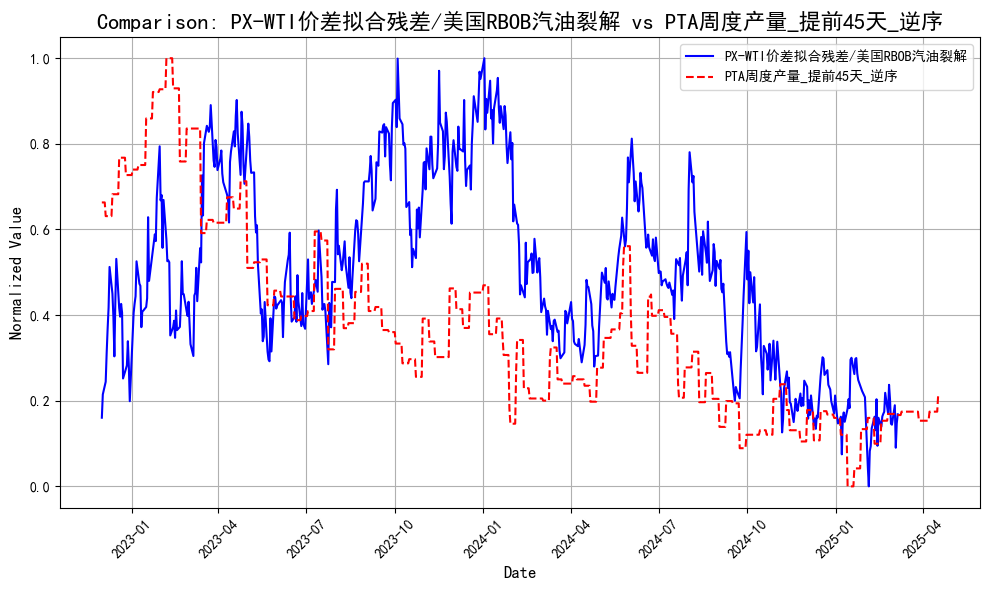

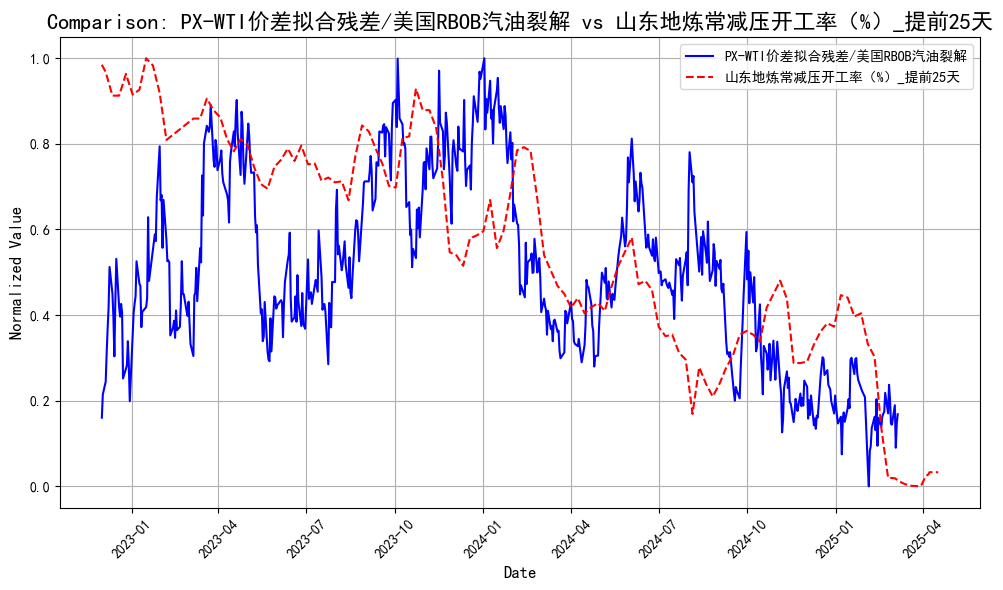

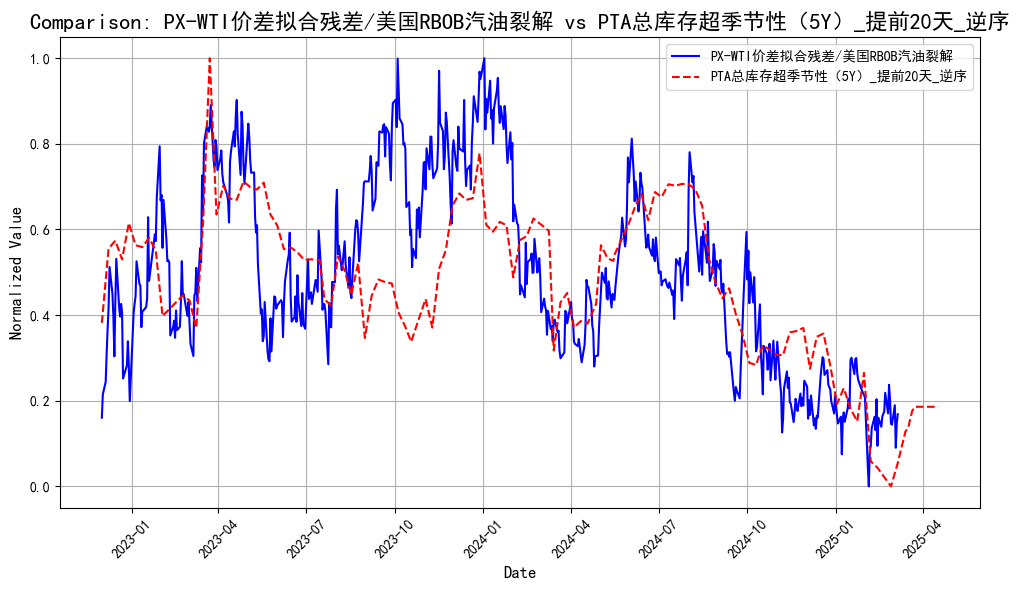

In [5]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='PX-WTI价差拟合残差/美国RBOB汽油裂解', 
    compare_cols=[
        'PTA周度产量_提前45天_逆序',
        '山东地炼常减压开工率（%）_提前25天',
        'PTA总库存超季节性（5Y）_提前20天_逆序'
       ]
)

In [6]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 90
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        'PTA周度产量_提前45天_逆序',
        '山东地炼常减压开工率（%）_提前25天',
        'PTA总库存超季节性（5Y）_提前20天_逆序'
]

predict_column = 'PX-WTI价差拟合残差/美国RBOB汽油裂解'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.05,  # 较小的学习率
    'max_depth': 4,  # 控制树的深度防止过拟合
    'min_child_weight': 8,  # 控制过拟合
    'subsample': 1,  # 随机采样防止过拟合
    'colsample_bytree': 1,  # 特征随机采样
    'gamma': 0.1,  # 控制分裂
    'reg_alpha': 0.1,  # L1正则化
    'reg_lambda': 1.0,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}

num_boost_round = 10000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=300,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=300 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:78.57311	train-rmse:42.52864


[300]	eval-rmse:35.66606	train-rmse:10.20160


[600]	eval-rmse:35.18666	train-rmse:7.72786


[900]	eval-rmse:34.70666	train-rmse:6.57207


[1200]	eval-rmse:35.07592	train-rmse:5.93575


[1500]	eval-rmse:35.22406	train-rmse:5.38031


[1800]	eval-rmse:35.17523	train-rmse:4.82123


[2100]	eval-rmse:35.63267	train-rmse:4.47085


[2400]	eval-rmse:35.71175	train-rmse:4.15331


[2700]	eval-rmse:35.95426	train-rmse:3.89257


[3000]	eval-rmse:35.86254	train-rmse:3.62707


[3300]	eval-rmse:35.86744	train-rmse:3.41892


[3600]	eval-rmse:35.92189	train-rmse:3.22816


[3900]	eval-rmse:36.08722	train-rmse:3.07765


[4200]	eval-rmse:36.34128	train-rmse:2.94052


[4500]	eval-rmse:36.35574	train-rmse:2.80079


[4800]	eval-rmse:36.51152	train-rmse:2.70807


[5092]	eval-rmse:36.51152	train-rmse:2.70807


训练集 MSE (DMatrix): 7.4037, 训练集 R² (DMatrix): 0.9963
测试集 MSE (DMatrix): 1333.0911, 测试集 R² (DMatrix): -6.2394


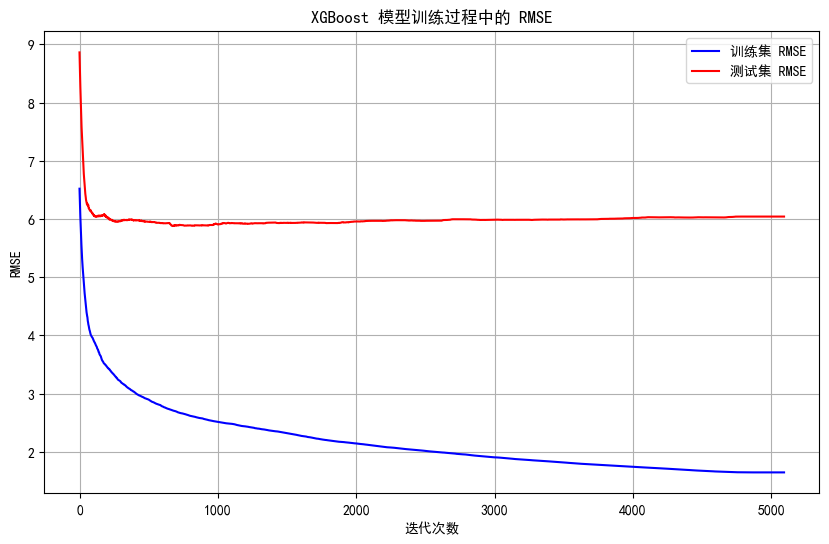

In [7]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)
all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=300,
    evals_result=evals_result,
    verbose_eval=300
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:46.17212


[300]	train-rmse:10.33195


[600]	train-rmse:7.69149


[900]	train-rmse:6.53296


[1200]	train-rmse:5.86712

[1500]	train-rmse:5.37881

[1800]	train-rmse:4.98855

[2100]	train-rmse:4.68694

[2400]	train-rmse:4.37269


[2700]	train-rmse:4.12803

[3000]	train-rmse:3.90278


[3300]	train-rmse:3.70229

[3600]	train-rmse:3.54686


[3900]	train-rmse:3.38153


[4200]	train-rmse:3.25480


[4500]	train-rmse:3.11764


[4800]	train-rmse:3.00439


[5100]	train-rmse:2.92312

[5302]	train-rmse:2.92312


全部数据 MSE: 8.7362, 全部数据 R²: 0.9964

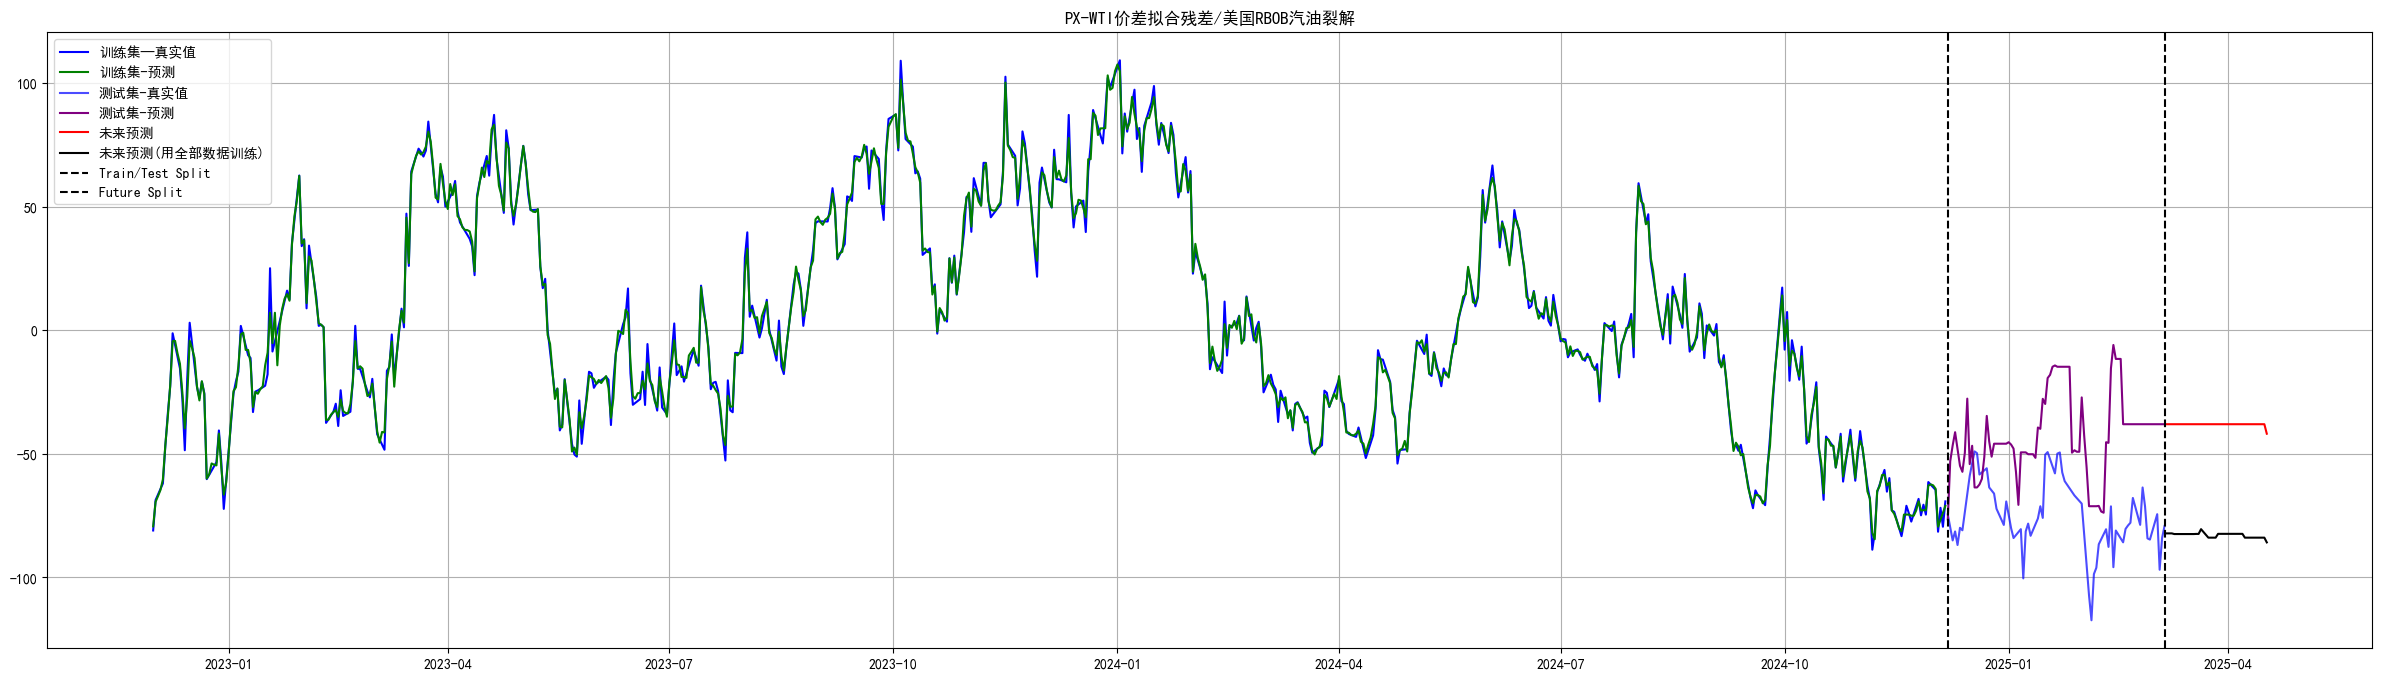

In [9]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('PX-WTI价差拟合残差/美国RBOB汽油裂解')
plt.legend()
plt.grid(True)
plt.show()

---

In [10]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/PX-WTI价差拟合残差-美国RBOB汽油裂解_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/PX-WTI价差拟合残差-美国RBOB汽油裂解_月度数据.xlsx', index=False,float_format= '%.0f')

In [11]:
merged_df_daily.head()

,Date,真实值,预测值
827,2025/04/17,NaN,-85.822937
826,2025/04/16,NaN,-83.905502
825,2025/04/15,NaN,-83.905502
824,2025/04/14,NaN,-83.905502
823,2025/04/11,NaN,-83.905502
